# Bayesian Linear Regression

In [27]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate(); 

  Activating project at `~/Documents/GitHub/RxInfer.jl/examples`


In [2]:
using RxInfer, Random, Plots, StableRNGs, BenchmarkTools, LinearAlgebra, StatsPlots

John recently purchased a new car and is interested in its fuel consumption rate. He believes that this rate has a linear relationship with speed, and as such, he wants to conduct tests by driving his car on different types of roads, recording both the fuel usage and speed. In order to determine the fuel consumption rate, John employs Bayesian linear regression.

## Univariate regression with known noise

First, he drives the car on a urban road. John enjoys driving on the well-built, wide, and flat urban roads. Urban roads also offer the advantage of precise fuel consumption measurement with minimal noise. It is easy for John to build the equation bellow:

$$\begin{aligned}
p(y_i) = \mathcal{N}(y_i | a * x_i + b , 1.0)
\end{aligned}$$

The recorded speed is denoted as $x_i \in \mathbb{R}$ and the recorded fuel consumption as $y_i \in \mathbb{R}$. The coefficients $a$ and $b$ need to be estimated. Prior beliefs on $a$ and $b$ are informed by the vehicle manual.

$$\begin{aligned}
    p(a) &= \mathcal{N}(a|m_a, v_a) \\
    p(b) &= \mathcal{N}(b|m_b, v_b) 
\end{aligned}$$

He records the speed and fuel consumption for the urban road which is the `xdata` and `ydata`.

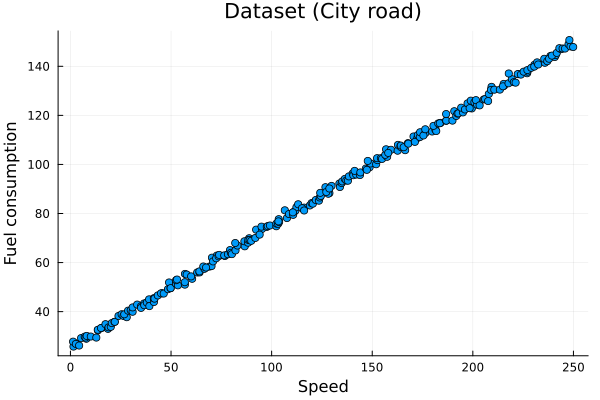

In [3]:
reala = 0.5
realb = 25.0
realv = 1.0

N = 250

rng = StableRNG(1234)

xorig = collect(1:N)

xdata = xorig .+ randn(rng, N)
ydata = rand.(NormalMeanVariance.(realb .+ reala .* xorig, realv))

scatter(xdata, ydata, title = "Dataset (City road)", legend=false)
xlabel!("Speed")
ylabel!("Fuel consumption")

In order to estimate the two parameters with the recorded data, he uses a `RxInfer.jl` to create a model.

In [4]:
@model function linear_regression(n)
    a ~ NormalMeanVariance(0.0, 1.0)
    b ~ NormalMeanVariance(0.0, 100.0)
    
    x = datavar(Float64, n)
    y = datavar(Float64, n)
    
    for i in 1:n
        y[i] ~ NormalMeanVariance(a * x[i] + b, 1.0)
    end
end

He is delighted that he can utilize the inference function from this package, saving him the effort of starting from scratch and enabling him to obtain the desired results for this road.

In [28]:
results = inference(
    model = linear_regression(length(xdata)), 
    data  = (y = ydata, x = xdata), 
    initmessages = (b = NormalMeanVariance(0.0, 100.0), ), 
    returnvars   = (a = KeepLast(), b = KeepLast()), 
    iterations = 20,
);

In [29]:
println(results)

Inference results:
  Posteriors       | available for (a, b)



He knows the theoretical coefficients and noise for this car from the manual. He is going to compare the experimental solution with theoretical results.

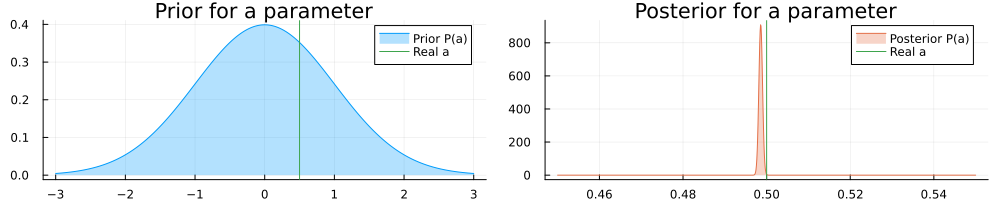

In [30]:
pra = plot(range(-3, 3, length = 1000), (x) -> pdf(NormalMeanVariance(0.0, 1.0), x), title="Prior for a parameter", fillalpha=0.3, fillrange = 0, label="Prior P(a)", c=1,)
pra = vline!(pra, [ reala ], label="Real a", c = 3)
psa = plot(range(0.45, 0.55, length = 1000), (x) -> pdf(results.posteriors[:a], x), title="Posterior for a parameter", fillalpha=0.3, fillrange = 0, label="Posterior P(a)", c=2,)
psa = vline!(psa, [ reala ], label="Real a", c = 3)

plot(pra, psa, size = (1000, 200))

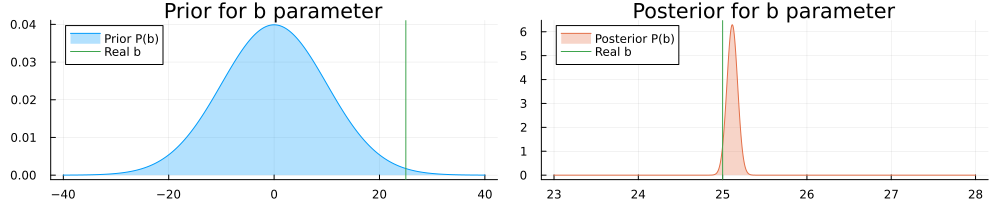

In [31]:
prb = plot(range(-40, 40, length = 1000), (x) -> pdf(NormalMeanVariance(0.0, 100.0), x), title="Prior for b parameter", fillalpha=0.3, fillrange = 0, label="Prior P(b)", c=1, legend = :topleft)
prb = vline!(prb, [ realb ], label="Real b", c = 3)
psb = plot(range(23, 28, length = 1000), (x) -> pdf(results.posteriors[:b], x), title="Posterior for b parameter", fillalpha=0.3, fillrange = 0, label="Posterior P(b)", c=2, legend = :topleft)
psb = vline!(psb, [ realb ], label="Real b", c = 3)

plot(prb, psb, size = (1000, 200))

In [32]:
a = results.posteriors[:a]
b = results.posteriors[:b]

println("Real a: ", reala, " | Estimated a: ", mean_var(a), " | Error: ", abs(mean(a) - reala))
println("Real b: ", realb, " | Estimated b: ", mean_var(b), " | Error: ", abs(mean(b) - realb))

Real a: 0.5 | Estimated a: (0.4985817941665956, 1.9152402435219974e-7) | Error: 0.0014182058334044068
Real b: 25.0 | Estimated b: (25.114439705363964, 0.004015967531215887) | Error: 0.11443970536396364


## Univariate regression with unknown noise

Afterwards, he plans to test the car on a mountain road. However, mountain roads are typically narrow and filled with small stones, which makes it more difficult to establish a clear relationship between fuel consumption and speed, leading to an unknown level of noise in the regression model. Therefore, he design a model with unknown Inverse-Gamma distribution.
$$\begin{aligned}
p(s) = \mathcal{IG}(s|\alpha, \theta)
\end{aligned}$$

In [33]:
@model function linear_regression_unknown_noise(n)
    a ~ NormalMeanVariance(0.0, 1.0)
    b ~ NormalMeanVariance(0.0, 100.0)
    s ~ InverseGamma(1.0, 1.0)
    
    x = datavar(Float64, n)
    y = datavar(Float64, n)
    
    for i in 1:n
        y[i] ~ NormalMeanVariance(a * x[i] + b, s)
    end
end

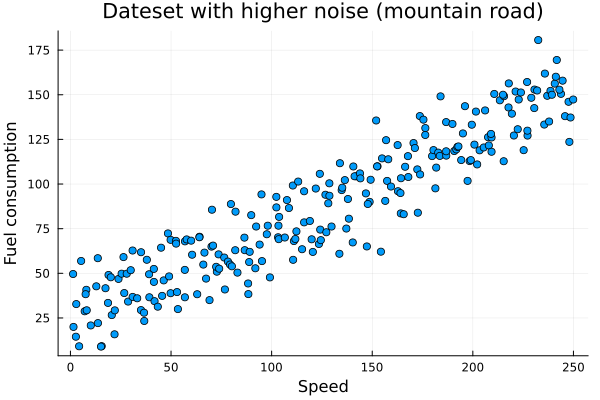

In [35]:
reala_un = 0.5
realb_un = 25.0
realv_un = 200.0

N_un = 250

rng_un = StableRNG(1234)

xorig_un = collect(1:N)

xdata_un = xorig_un .+ randn(rng_un, N_un)
ydata_un = rand.(NormalMeanVariance.(realb_un .+ reala_un .* xorig_un, realv_un))

scatter(xdata_un, ydata_un, title = "Dateset with higher noise (mountain road)", legend=false)
xlabel!("Speed")
ylabel!("Fuel consumption")

To solve this problem analytically he need to set `constraints = MeanField()` as well as provide initial marginals with the `initmarginals` argument. He are also going to evaluate the convergency performance of the algorithm with the `free_energy = true` option:

In [36]:
results_unknown_noise = inference(
    model = linear_regression_unknown_noise(length(xdata_un)), 
    data  = (y = ydata_un, x = xdata_un), 
    initmessages = (b = NormalMeanVariance(0.0, 100.0), ), 
    returnvars   = (a = KeepLast(), b = KeepLast(), s = KeepLast()), 
    iterations = 20,
    constraints = MeanField(),
    initmarginals = (s = vague(InverseGamma), ),
    free_energy = true
);

In [37]:
println(results_unknown_noise)

Inference results:
  Posteriors       | available for (a, b, s)
  Free Energy:     | Real[1656.74, 1157.21, 1087.74, 1069.15, 1056.61, 1048.82, 1044.2, 1041.51, 1039.96, 1039.07, 1038.55, 1038.25, 1038.08, 1037.98, 1037.91, 1037.88, 1037.85, 1037.84, 1037.83, 1037.82]



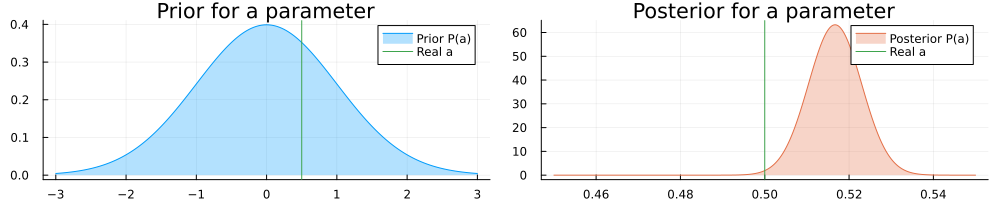

In [38]:
pra = plot(range(-3, 3, length = 1000), (x) -> pdf(NormalMeanVariance(0.0, 1.0), x), title="Prior for a parameter", fillalpha=0.3, fillrange = 0, label="Prior P(a)", c=1,)
pra = vline!(pra, [ reala_un ], label="Real a", c = 3)
psa = plot(range(0.45, 0.55, length = 1000), (x) -> pdf(results_unknown_noise.posteriors[:a], x), title="Posterior for a parameter", fillalpha=0.3, fillrange = 0, label="Posterior P(a)", c=2,)
psa = vline!(psa, [ reala_un ], label="Real a", c = 3)

plot(pra, psa, size = (1000, 200))

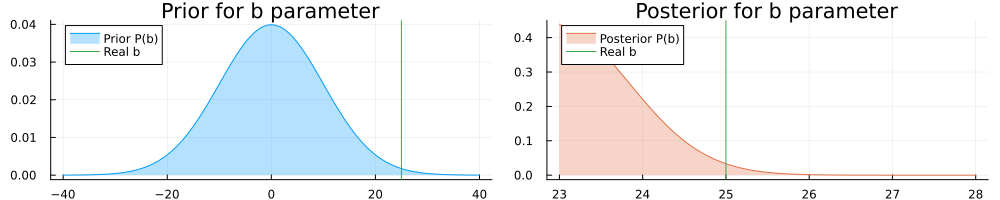

In [39]:
prb = plot(range(-40, 40, length = 1000), (x) -> pdf(NormalMeanVariance(0.0, 100.0), x), title="Prior for b parameter", fillalpha=0.3, fillrange = 0, label="Prior P(b)", c=1, legend = :topleft)
prb = vline!(prb, [ realb_un ], label="Real b", c = 3)
psb = plot(range(23, 28, length = 1000), (x) -> pdf(results_unknown_noise.posteriors[:b], x), title="Posterior for b parameter", fillalpha=0.3, fillrange = 0, label="Posterior P(b)", c=2, legend = :topleft)
psb = vline!(psb, [ realb_un ], label="Real b", c = 3)

plot(prb, psb, size = (1000, 200))

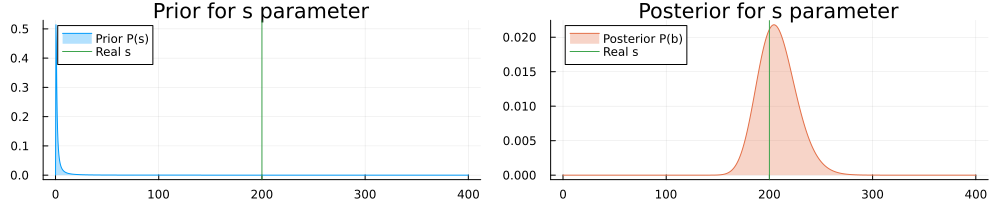

In [41]:
prb = plot(range(0.001, 400, length = 1000), (x) -> pdf(InverseGamma(1.0, 1.0), x), title="Prior for s parameter", fillalpha=0.3, fillrange = 0, label="Prior P(s)", c=1, legend = :topleft)
prb = vline!(prb, [ realv_un ], label="Real s", c = 3)
psb = plot(range(0.001, 400, length = 1000), (x) -> pdf(results_unknown_noise.posteriors[:s], x), title="Posterior for s parameter", fillalpha=0.3, fillrange = 0, label="Posterior P(b)", c=2, legend = :topleft)
psb = vline!(psb, [ realv_un ], label="Real s", c = 3)

plot(prb, psb, size = (1000, 200))

He sees that in the presence of more noise the inference result is more uncertain about the actual values for $a$ and $b$ parameters.

John samples $a$ and $b$ and plot many possible regression lines on the same plot:

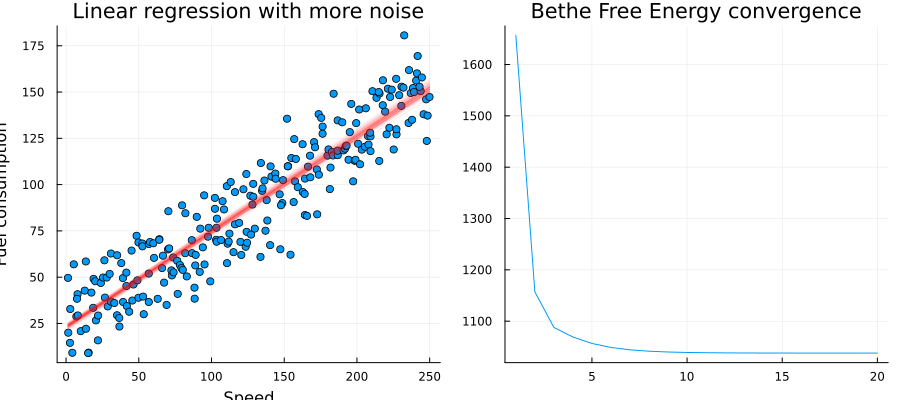

In [42]:
as = rand(results_unknown_noise.posteriors[:a], 100)
bs = rand(results_unknown_noise.posteriors[:b], 100)
p = scatter(xdata_un, ydata_un, title = "Linear regression with more noise", legend=false)
xlabel!("Speed")
ylabel!("Fuel consumption")
for (a, b) in zip(as, bs)
    global p = plot!(p, xdata_un, a .* xdata_un .+ b, alpha = 0.05, color = :red)
end

f = plot(results_unknown_noise.free_energy, title = "Bethe Free Energy convergence", label = nothing)

plot(p, f, size = (900, 400))

From this plot John can see that many lines do fit the data well and there is no definite "best" answer to the regression coefficients. He realize that most of these lines, however, resemble a similar angle and shift. Bethe Free Energy plot on the right hand side indicates that the inference procedure converged normally.

## Multivariate linear regression

In addition to fuel consumption, he is also interested in evaluating the car's power performance, braking performance, handling stability, smoothness, and other factors. To investigate the car's performance, he includes additional measurements. Essentially, this approach involves performing multiple linear regression tasks simultaneously, using multiple data vectors for x and y with different levels of noise. As in the previous example, he assumes the level of noise to be unknown.

In [18]:
@model function linear_regression_multivariate(m, n)
    a ~ MvNormalMeanCovariance(zeros(m), 100 * diageye(m))
    b ~ MvNormalMeanCovariance(ones(m), 100 * diageye(m))
    W ~ InverseWishart(m + 2, 100 * diageye(m))

    # Here is a small trick to make the example work
    # We treat the `x` vector as a Diagonal matrix such that we can multiply it with `a`
    x = datavar(Diagonal{Float64, Vector{Float64}}, n)
    y = datavar(Vector{Float64}, n)
    z = randomvar(n)

    z .~ x .* a .+ b
    y .~ MvNormalMeanCovariance(z, W)

end

After received all the measurement records, he plots the measurements and performance index:

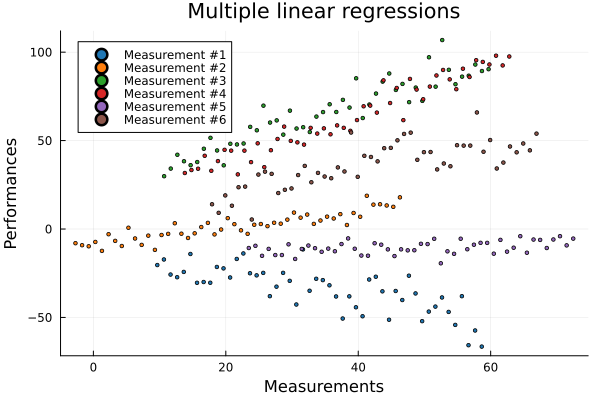

In [43]:

N_mv = 50
s_mv = floor(N_mv / 10)
d_mv = 6

rng_mv = StableRNG(42)

a_mv = randn(rng_mv, d_mv)
b_mv = 10 * randn(rng_mv, d_mv)
v_mv = 100 * rand(rng_mv, d_mv)

x_mv = []
y_mv = []

p = plot(title = "Multiple linear regressions", legend = :topleft)

plt = palette(:tab10)

data_set_label = [""]

for k in 1:d_mv
    x_mv_k = collect((1 + s_mv * (k - 1)):(N_mv + s_mv * (k - 1))) .+ 10 * randn()
    y_mv_k = rand.(NormalMeanVariance.(a_mv[k] .* x_mv_k .+ b_mv[k], v_mv[k]))

    global p = scatter!(p, x_mv_k, y_mv_k, label = "Measurement #$k", ms = 2, color = plt[k])

    push!(x_mv, x_mv_k)
    push!(y_mv, y_mv_k)
end
xlabel!("Measurements")
ylabel!("Performances")
p

In [44]:
xdata_mv = map(i -> Diagonal(getindex.(x_mv, i)), 1:N_mv)
ydata_mv = map(i -> getindex.(y_mv, i), 1:N_mv);

In [45]:
results_mv = inference(
    model = linear_regression_multivariate(d_mv, N_mv),
    data  = (y = ydata_mv, x = xdata_mv),
    initmarginals = (W = InverseWishart(d_mv + 2, 10 * diageye(d_mv)), ),
    initmessages = (b = MvNormalMeanCovariance(ones(d_mv), 10 * diageye(d_mv)), ),
    returnvars   = (a = KeepLast(), b = KeepLast(), W = KeepLast()),
    free_energy = true,
    iterations   = 50,
    constraints = MeanField()
)

Inference results:
  Posteriors       | available for (a, b, W)
  Free Energy:     | Real[923.289, 1048.54, 1040.11, 1033.29, 1028.53, 1024.51, 1021.05, 1018.12, 1015.65, 1013.57  …  1003.03, 1003.03, 1003.02, 1003.01, 1003.01, 1003.01, 1003.0, 1003.0, 1003.0, 1003.0]


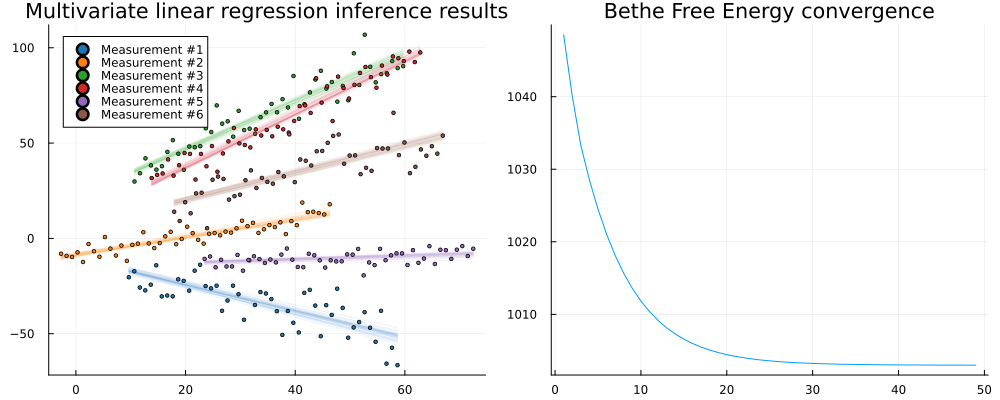

In [47]:
p = plot(title = "Multivariate linear regression inference results", legend = :topleft)

# how many lines to plot
r = 50

i_a = collect.(eachcol(rand(results_mv.posteriors[:a], r)))
i_b = collect.(eachcol(rand(results_mv.posteriors[:b], r)))

plt = palette(:tab10)

for k in 1:d_mv
    x_mv_k = x_mv[k]
    y_mv_k = y_mv[k]

    for i in 1:r
        global p = plot!(p, x_mv_k, x_mv_k .* i_a[i][k] .+ i_b[i][k], label = nothing, alpha = 0.05, color = plt[k])
    end

    global p = scatter!(p, x_mv_k, y_mv_k, label = "Measurement #$k", ms = 2, color = plt[k])
end

# truncate the init step
f = plot(results_mv.free_energy[2:end], title ="Bethe Free Energy convergence", label = nothing) 

plot(p, f, size = (1000, 400))

He needs more iterations to converge, but that is expected since the problem became multivariate and, hence, more difficult.

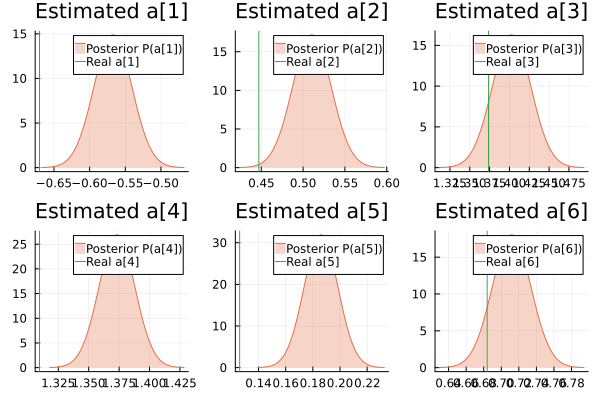

In [23]:
i_a_mv = results_mv.posteriors[:a]

ps_a = []

for k in 1:d_mv
    
    local _p = plot(title = "Estimated a[$k]")
    local m_a_mv_k = mean(i_a_mv)[k]
    local v_a_mv_k = std(i_a_mv)[k, k]
    
    _p = plot!(_p, Normal(m_a_mv_k, v_a_mv_k), fillalpha=0.3, fillrange = 0, label="Posterior P(a[$k])", c=2,)
    _p = vline!(_p, [ a_mv[k] ], label="Real a[$k]", c = 3)
           
    push!(ps_a, _p)
end

plot(ps_a...)

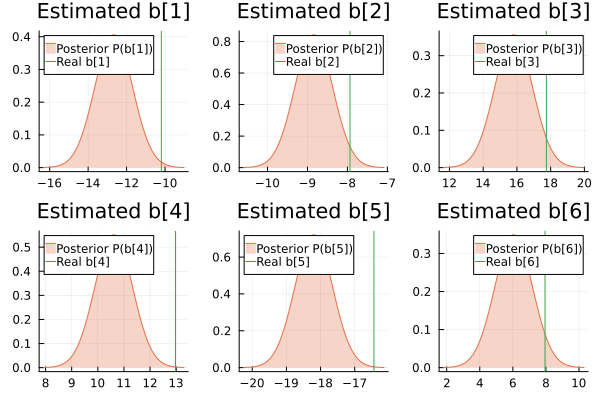

In [24]:
i_b_mv = results_mv.posteriors[:b]

ps_b = []

for k in 1:d_mv
    
    local _p = plot(title = "Estimated b[$k]")
    local m_b_mv_k = mean(i_b_mv)[k]
    local v_b_mv_k = std(i_b_mv)[k, k]

    _p = plot!(_p, Normal(m_b_mv_k, v_b_mv_k), fillalpha=0.3, fillrange = 0, label="Posterior P(b[$k])", c=2,)
    _p = vline!(_p, [ b_mv[k] ], label="Real b[$k]", c = 3)
           
    push!(ps_b, _p)
end

plot(ps_b...)

He also checks the noise estimation procedure and finds the noise components with high precision:

In [25]:
v_mv

6-element Vector{Float64}:
 63.75837562301017
 11.035887151354174
 59.851445480565424
 32.21105133173212
 16.228513601930295
 64.33685320974074

In [26]:
diag(mean(results_mv.posteriors[:W]))

6-element Vector{Float64}:
 47.87719090325086
 11.109162953139448
 63.94119459567097
 26.640922772108283
 17.23535111688244
 71.10114010045234